In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
import jieba
import re
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"]="0"
from keras.models import Model
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from keras.optimizers import RMSprop
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.callbacks import EarlyStopping
%matplotlib inline

Using TensorFlow backend.


前两次都没有用到标题数据，这次我们将标题加入其中。

In [2]:
# 读取数据集
def load_data():
    # 读取训练集
    train_file = open("./toutiao_category_train.txt", encoding='utf-8')
    train_collection = train_file.readlines()
    train_data = []
    for i in train_collection:
        i = i.split("_!_")
        i[4] = i[4].strip()
        i[4] = " ".join(i[4].split(",")) + " " + " ".join(jieba.cut(re.sub(r'[^\w\s]','',i[3].strip()), cut_all=False))
        i.append(len(i[4].split(" ")))
        i.pop(0)
        i.pop(2)
        train_data.append(i)
    train_df = pd.DataFrame(train_data)
    train_df.columns = ["label_index", "label", "cutword", "cutwordnum"]
    
    # 读取验证集
    val_file = open("./toutiao_category_dev.txt", encoding='utf-8')
    val_collection = val_file.readlines()
    val_data = []
    for i in val_collection:
        i =i.split("_!_")
        i[4] = i[4].strip()
        i[4] = " ".join(i[4].split(",")) + " " + " ".join(jieba.cut(re.sub(r'[^\w\s]','',i[3].strip()), cut_all=False))
        i.append(len(i[4].split(" ")))
        i.pop(0)
        i.pop(2)
        val_data.append(i)
    val_df = pd.DataFrame(val_data)
    val_df.columns = ["label_index", "label", "cutword", "cutwordnum"]
    
    # 读取测试集
    test_file = open("./toutiao_category_test.txt", encoding='utf-8')
    test_collection = test_file.readlines()
    test_data = []
    for i in test_collection:
        i =i.split("_!_")
        i[4] = i[4].strip()
        i[4] = " ".join(i[4].split(",")) + " " + " ".join(jieba.cut(re.sub(r'[^\w\s]','',i[3].strip()), cut_all=False))
        i.append(len(i[4].split(" ")))
        i.pop(0)
        i.pop(2)
        test_data.append(i)
    test_df = pd.DataFrame(test_data)
    test_df.columns = ["label_index", "label", "cutword", "cutwordnum"]
    
    return train_df, val_df, test_df

In [3]:
train_df, val_df, test_df = load_data()

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\yinzh\AppData\Local\Temp\jieba.cache
Loading model cost 0.839 seconds.
Prefix dict has been built successfully.


In [4]:
train_df.head()

,label_index,label,cutword,cutwordnum
0,104,news_finance,股票 股票 中 的 突破 形态,6
1,102,news_entertainment,三生三世十里桃花 张智尧 杨门女将之女儿当自强 陆小凤 印象深刻 陆小凤传奇 杨宗保 花满楼...,24
2,102,news_entertainment,陈伟霆 黄晓明 粉丝 陈伟霆 和 黄晓明 真的 有 差别 难怪 baby 会 选择 黄晓明,14
3,107,news_car,驾驶证 科目 驾驶证 科目 几 最难,6
4,104,news_finance,上年同期 紫贝龙 紫贝龙 2017 年 营收 1644 万元 业绩 亏损 1425 万元,14


数据探索

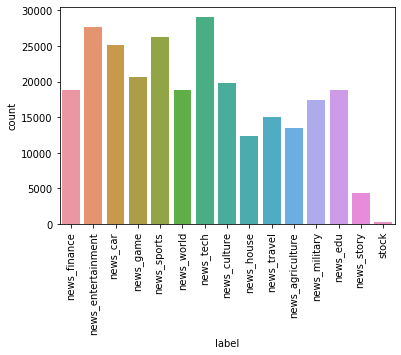

In [5]:
## 查看训练集都有哪些标签
plt.figure()
sns.countplot(train_df.label)
plt.xlabel('label')
plt.xticks(rotation=90)
plt.show()

共15种标签，标签分布比较均匀。

count    267881.000000
mean         15.276067
std           5.061635
min           2.000000
25%          11.000000
50%          16.000000
75%          19.000000
max          83.000000
Name: cutwordnum, dtype: float64


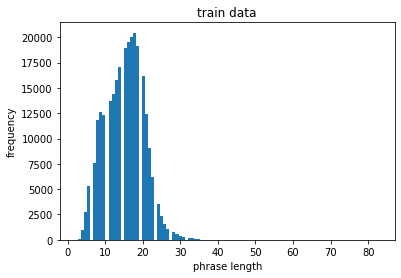

In [6]:
## 分析训练集中词组数量的分布
print(train_df.cutwordnum.describe())
plt.figure()
plt.hist(train_df.cutwordnum,bins=100)
plt.xlabel("phrase length")
plt.ylabel("frequency")
plt.title("train data")
plt.show()

In [7]:
## 对数据集的标签数据进行重新编码
train_y = train_df.label
val_y = val_df.label
test_y = test_df.label
le = LabelEncoder()
train_y = le.fit_transform(train_y).reshape(-1,1)
val_y = le.transform(val_y).reshape(-1,1)
test_y = le.transform(test_y).reshape(-1,1)

## 对数据集的标签数据进行one-hot编码
ohe = OneHotEncoder()
train_y = ohe.fit_transform(train_y).toarray()
val_y = ohe.transform(val_y).toarray()
test_y = ohe.transform(test_y).toarray()

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


使用Tokenizer对词组进行编码

In [8]:
max_words = 5000
max_len = 600
tok = Tokenizer(num_words=max_words)  ## 使用的最大词语数为5000
tok.fit_on_texts(train_df.cutword)

## 使用word_index属性可以看到每次词对应的编码
## 使用word_counts属性可以看到每个词对应的频数
for ii,iterm in enumerate(tok.word_index.items()):
    if ii < 10:
        print(iterm)
    else:
        break
print("===================")  
for ii,iterm in enumerate(tok.word_counts.items()):
    if ii < 10:
        print(iterm)
    else:
        break

('的', 1)
('了', 2)
('是', 3)
('你', 4)
('吗', 5)
('有', 6)
('在', 7)
('如何', 8)
('什么', 9)
('怎么', 10)
('股票', 1461)
('中', 5965)
('的', 105479)
('突破', 424)
('形态', 152)
('三生三世十里桃花', 183)
('张智尧', 12)
('杨门女将之女儿当自强', 1)
('陆小凤', 9)
('印象深刻', 3)


使用tok.texts_to_sequences()将数据转化为序列，并使用sequence.pad_sequences()将每个序列调整为相同的长度。

In [9]:
## 对每个词编码之后，每句新闻中的每个词就可以用对应的编码表示，即每条新闻可以转变成一个向量了：
train_seq = tok.texts_to_sequences(train_df.cutword)
val_seq = tok.texts_to_sequences(val_df.cutword)
test_seq = tok.texts_to_sequences(test_df.cutword)
## 将每个序列调整为相同的长度
train_seq_mat = sequence.pad_sequences(train_seq,maxlen=max_len)
val_seq_mat = sequence.pad_sequences(val_seq,maxlen=max_len)
test_seq_mat = sequence.pad_sequences(test_seq,maxlen=max_len)

print(train_seq_mat.shape)
print(val_seq_mat.shape)
print(test_seq_mat.shape)

(267881, 600)
(57403, 600)
(57404, 600)


建立LSTM模型并训练

In [10]:
## 定义LSTM模型
inputs = Input(name='inputs',shape=[max_len])
## Embedding(词汇表大小,batch大小,每个新闻的词长)
layer = Embedding(max_words+1,128,input_length=max_len)(inputs)
layer = LSTM(16)(layer)
# layer = Dense(16,activation="relu",name="FC1")(layer)
# layer = Dropout(0.5)(layer)
layer = Dense(15,activation="softmax",name="FC2")(layer)
model = Model(inputs=inputs,outputs=layer)
model.summary()
model.compile(loss="categorical_crossentropy",optimizer=RMSprop(),metrics=["accuracy"])

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          (None, 600)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 600, 128)          640128    
_________________________________________________________________
lstm_1 (LSTM)                (None, 16)                9280      
_________________________________________________________________
FC2 (Dense)                  (None, 15)                255       
Total params: 649,663
Trainable params: 649,663
Non-trainable params: 0
_________________________________________________________________


模型建立好之后，开始进行训练

In [11]:
## 模型训练
model_fit = model.fit(train_seq_mat,train_y,batch_size=1024,epochs=10,
                      validation_data=(val_seq_mat,val_y),
                      callbacks=[EarlyStopping(monitor='val_loss',min_delta=0.0001)] ## 当val-loss不再提升时停止训练
                     )


Train on 267881 samples, validate on 57403 samples
Epoch 1/10
267881/267881 [==============================] - 635s 2ms/step - loss: 1.7694 - accuracy: 0.5039 - val_loss: 1.0497 - val_accuracy: 0.7672
Epoch 2/10
267881/267881 [==============================] - 813s 3ms/step - loss: 0.7931 - accuracy: 0.8059 - val_loss: 0.6869 - val_accuracy: 0.8174
Epoch 3/10
267881/267881 [==============================] - 744s 3ms/step - loss: 0.6208 - accuracy: 0.8336 - val_loss: 0.6235 - val_accuracy: 0.8277
Epoch 4/10
267881/267881 [==============================] - 744s 3ms/step - loss: 0.5679 - accuracy: 0.8431 - val_loss: 0.6023 - val_accuracy: 0.8299
Epoch 5/10
267881/267881 [==============================] - 704s 3ms/step - loss: 0.5393 - accuracy: 0.8477 - val_loss: 0.5847 - val_accuracy: 0.8345
Epoch 6/10
267881/267881 [==============================] - 686s 3ms/step - loss: 0.5196 - accuracy: 0.8519 - val_loss: 0.5797 - val_accuracy: 0.8346
Epoch 7/10
267881/267881 [======================

In [12]:
## 对测试集进行预测
test_pre = model.predict(test_seq_mat)

## 评价预测效果，计算混淆矩阵
confm = metrics.confusion_matrix(np.argmax(test_pre,axis=1),np.argmax(test_y,axis=1))

In [13]:
list(train_df.label.drop_duplicates())

['news_finance',
 'news_entertainment',
 'news_car',
 'news_game',
 'news_sports',
 'news_world',
 'news_tech',
 'news_culture',
 'news_house',
 'news_travel',
 'news_agriculture',
 'news_military',
 'news_edu',
 'news_story',
 'stock']

In [14]:
Labname =  list(train_df.label.drop_duplicates())

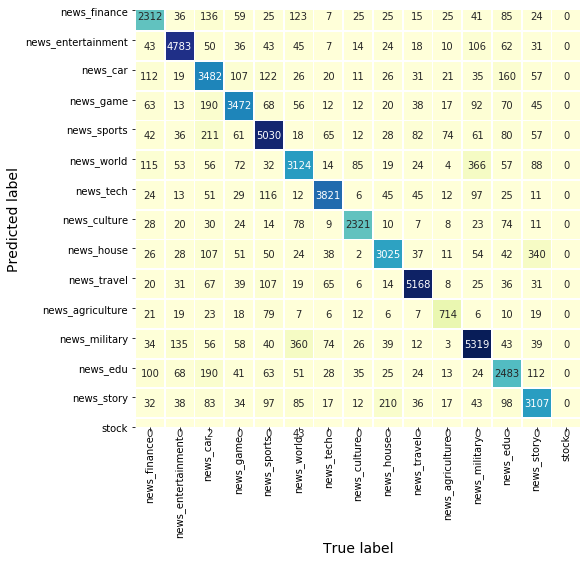

              precision    recall  f1-score   support

           0       0.79      0.78      0.78      2972
           1       0.91      0.90      0.91      5292
           2       0.82      0.74      0.78      4734
           3       0.83      0.85      0.84      4101
           4       0.86      0.85      0.86      5886
           5       0.76      0.77      0.76      4071
           6       0.89      0.91      0.90      4183
           7       0.87      0.90      0.89      2579
           8       0.79      0.86      0.82      3516
           9       0.92      0.93      0.92      5544
          10       0.75      0.76      0.76       937
          11       0.85      0.85      0.85      6292
          12       0.76      0.75      0.75      3325
          13       0.79      0.78      0.79      3972
          14       0.00      0.00      0.00         0

    accuracy                           0.84     57404
   macro avg       0.77      0.78      0.77     57404
weighted avg       0.84   

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [15]:
## 混淆矩阵可视化
plt.figure(figsize=(8,8))
sns.heatmap(confm.T, square=True, annot=True,
            fmt='d', cbar=False,linewidths=.8,
            cmap="YlGnBu")
plt.xlabel('True label',size = 14)
plt.ylabel('Predicted label',size = 14)
plt.xticks(np.arange(15)+0.5,Labname,rotation=90)
plt.yticks(np.arange(15)+0.3,Labname,rotation=0)
plt.show()


print(metrics.classification_report(np.argmax(test_pre,axis=1),np.argmax(test_y,axis=1)))

训练时间：1小时，准确率：84%，相比之前提升明显，可以看到添加标题内容，使用适合参数对于测试结果有非常高的提升，

In [16]:
## 保存训练好的Tokenizer，和导入
# import pickle
# # saving
# with open('tok.pickle', 'wb') as handle:
#     pickle.dump(tok, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [17]:
# # loading
# with open('tok.pickle', 'rb') as handle:
#     tok = pickle.load(handle)
# ## 使用word_index属性可以看到每次词对应的编码
# ## 使用word_counts属性可以看到每个词对应的频数
# for ii,iterm in enumerate(tok.word_index.items()):
#     if ii < 10:
#         print(iterm)
#     else:
#         break
# print("===================")  
# for ii,iterm in enumerate(tok.word_counts.items()):
#     if ii < 10:
#         print(iterm)
#     else:
#         break

In [18]:
## 模型的保存和导入
from keras.models import load_model
# 保存模型
model.save('LSTM_tnews_better_model.h5')  

In [19]:
# # 导入已经训练好的模型
# model = load_model('my_model.h5')
# ## 使用tok对验证数据集重新预处理
# val_seq = tok.texts_to_sequences(val_df.cutword)
# ## 将每个序列调整为相同的长度
# val_seq_mat = sequence.pad_sequences(val_seq,maxlen=max_len)
# ## 对验证集进行预测
# val_pre = model.predict(val_seq_mat)
# print(metrics.classification_report(np.argmax(val_pre,axis=1),np.argmax(val_y,axis=1)))